## Imports

In [5]:
from keras.models import Sequential, load_model
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, LeakyReLU
from keras.preprocessing import image
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import scipy.io as sio


import PIL
import os
import shutil

C:\Users\JW\Anaconda3\envs\dsi\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


## Load in data

In [1]:
import pandas as pd

df = pd.read_csv('all_images').drop(columns ='Unnamed: 0')
df.head()

,Image,class_num,bbox0,bbox1,bbox2,bbox3,Full Name,Year,Make,Model,Body Style,filepath
0,00001.jpg,14,39,116,569,375,Audi TTS Coupe 2012,2012,Audi,TTS,Coupe,train00001.jpg
1,00002.jpg,3,36,116,868,587,Acura TL Sedan 2012,2012,Acura,TL,Sedan,train00002.jpg
2,00003.jpg,91,85,109,601,381,Dodge Dakota Club Cab 2007,2007,Dodge,Dakota,Pickup,train00003.jpg
3,00004.jpg,134,621,393,1484,1096,Hyundai Sonata Hybrid Sedan 2012,2012,Hyundai,Sonata,Sedan,train00004.jpg
4,00005.jpg,106,14,36,133,99,Ford F-450 Super Duty Crew Cab 2012,2012,Ford,F-450,Pickup,train00005.jpg


In [4]:
for column in df.columns:
    print(column, len(df[column].unique()))

Image 8144
class_num 196
bbox0 504
bbox1 620
bbox2 1739
bbox3 1307
Full Name 196
Year 16
Make 48
Model 157
Body Style 9
filepath 16185


## Train/test split

In [3]:
df_train,  df_test = train_test_split(df, test_size = .3, stratify = df['Body Style'])

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

## Augment images using ImageDataGenerator

In [4]:
datagen = image.ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization = True,
    rescale = 1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

data_set_train = datagen.flow_from_dataframe(df_train, 'all/', 'filepath', 'Body Style',  target_size = (128, 128), batch_size = 32, color_mode='grayscale')
data_set_test = datagen.flow_from_dataframe(df_test, 'all', 'filepath', 'Body Style',  target_size = (128, 128), batch_size = 32, color_mode='grayscale')

Found 11329 images belonging to 9 classes.
Found 4856 images belonging to 9 classes.


## View augmented images(i.e. what the model sees as input)

'Sedan'

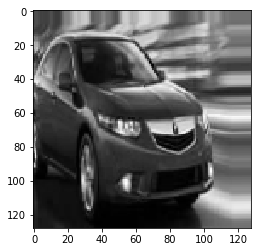

In [68]:
i =np.random.randint(0,32)
j = np.random.randint(0,32)

plt.imshow(data_set_train[i][0][j].reshape(128, 128), cmap=plt.get_cmap('gray'));

list(data_set_train.class_indices.keys())[data_set_train[i][1][j].tolist().index(1)]

## Instantiate and compile sequential neural net

In [20]:
classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), activation='linear', input_shape = (128, 128, 1)))
classifier.add(LeakyReLU())
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.4))

classifier.add(Conv2D(32, (6, 3), activation='linear'))
classifier.add(LeakyReLU())
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.4))

classifier.add(Conv2D(32, (3, 6), activation='linear'))
classifier.add(LeakyReLU())
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.4))

classifier.add(Flatten())

classifier.add(Dense(18, activation='linear'))
classifier.add(LeakyReLU())
classifier.add(Dropout(0.4))

classifier.add(Dense(9, activation='relu'))

classifier.add(Dense(units = 9, activation='softmax'))

classifier.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])

## Fit neural net to image data and train model

In [31]:
classifier.fit_generator(data_set_train, epochs = 5, steps_per_epoch = len(data_set_train), validation_data=data_set_test, validation_steps = len(data_set_test))

Epoch 1/5
355/355 [==============================] - 145s 408ms/step - loss: 1.6513 - acc: 0.3637 - val_loss: 3.0931 - val_acc: 0.3089
Epoch 2/5
355/355 [==============================] - 141s 396ms/step - loss: 1.6531 - acc: 0.3571 - val_loss: 2.9865 - val_acc: 0.3326
Epoch 3/5
355/355 [==============================] - 140s 395ms/step - loss: 1.6591 - acc: 0.3624 - val_loss: 2.9415 - val_acc: 0.3009
Epoch 4/5
355/355 [==============================] - 139s 391ms/step - loss: 1.6553 - acc: 0.3590 - val_loss: 2.9205 - val_acc: 0.3060
Epoch 5/5
355/355 [==============================] - 140s 394ms/step - loss: 1.6538 - acc: 0.3574 - val_loss: 2.8432 - val_acc: 0.3005


## Save model

In [71]:
classifier.save('model_bodystyle_6 (1)')

NameError: name 'classifier' is not defined

In [76]:
classifier = load_model('model_bodystyle_6 (1)')

ValueError: Unknown layer:name

## View model predictions on randomly selected image

In [ ]:
randomnum = np.random.randint(0, len(df))

test_image = image.load_img('all/'+df['filepath'].tolist()[randomnum], target_size=(128,128), color_mode='grayscale')

plt.imshow(test_image);

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
pd.DataFrame(result[0],data_set_test.class_indices).sort_values(0, ascending = False).head()